# Fourier Feature INR (Implicit Neural Representation) for BraTS 2023 Tumour Segmentation (JAX)

This notebook implements a coordinate-based MLP (implicit neural representation) with Fourier feature embeddings trained to predict voxel-wise tumour labels for BraTS 2023 volumes.

Instead of a 3D CNN (e.g. nnU-Net), we treat segmentation as learning a function: 
$( f: (x,y,z, m_{t1n}, m_{t1c}, m_{t2w}, m_{t2f}) 	o 	\ext{class logits} $).

We sample coordinates and associated multi-modal intensities to train an MLP with Fourier features for higher frequency representation capacity.

Notes: 
- This is a proof-of-concept; full convergence requires many iterations.
- Memory/time constraints mean we sample sparse coordinates per step.
- BraTS labels: 0=background, 1=NCR/NET, 2=ED, 3=ET.
- Dice scores are computed per class on a validation case.
- Compare conceptually to nnU-Net (dense 3D convolutions + data augmentation).


In [1]:
# Imports
import os, math, json, time, pathlib, functools
from typing import Tuple, Dict, Any
import numpy as np
import jax
import jax.numpy as jnp
import optax
import nibabel as nib
from dataclasses import dataclass

print('JAX devices:', jax.devices())


JAX devices: [CpuDevice(id=0)]


In [14]:
# Configuration
DATA_ROOT = pathlib.Path('../data/BraTS-2023')  # training subset root
SAVE_PATH = pathlib.Path('../artifacts/inr_brats23.npz')
CASE_LIMIT = 16  # limit number of cases for demonstration (adjust for more)
BATCH_SIZE = 8192  # number of coordinate samples per step
FOURIER_FREQS = 16  # number of Fourier frequency pairs per axis
HIDDEN_DIMS = [256, 256, 256, 256]  # MLP hidden layers
LR = 2e-3
TRAIN_STEPS = 10000  # increase for better performance
VAL_CASE_INDEX = 0  # which loaded case to evaluate on
RNG_SEED = 42
NUM_CLASSES = 4

jax_key = jax.random.PRNGKey(RNG_SEED)
print(f'Using {CASE_LIMIT} cases, batch {BATCH_SIZE}, steps {TRAIN_STEPS}')


Using 16 cases, batch 8192, steps 10000


## Data Loading Utilities
We load each BraTS case's modalities and segmentation. Modalities are z-score normalized per volume.

In [3]:
MODALITY_SUFFIXES = ['t1n', 't1c', 't2w', 't2f']
SEG_SUFFIX = 'seg'

def find_cases(root: pathlib.Path):
    cases = []
    for p in sorted(root.iterdir()):
        if p.is_dir():
            # Expect at least one modality and seg present
            if any((p / f'{p.name}-{m}.nii.gz').exists() for m in MODALITY_SUFFIXES):
                cases.append(p)
    return cases

def load_case(case_dir: pathlib.Path) -> Tuple[np.ndarray, np.ndarray]:
    base = case_dir.name
    mods = []
    for suf in MODALITY_SUFFIXES:
        fp = case_dir / f'{base}-{suf}.nii.gz'
        img = nib.load(str(fp))
        arr = img.get_fdata().astype(np.float32)
        # z-score normalization ignoring zeros
        mask = arr != 0
        if mask.any():
            mu = arr[mask].mean(); sigma = arr[mask].std() + 1e-6
            arr = (arr - mu) / sigma
        mods.append(arr)
    seg_fp = case_dir / f'{base}-{SEG_SUFFIX}.nii.gz'
    seg = nib.load(str(seg_fp)).get_fdata().astype(np.int16)
    mods_arr = np.stack(mods, axis=0)  # (M, H, W, D)
    return mods_arr, seg

all_cases = find_cases(DATA_ROOT)[:CASE_LIMIT]
print('Loaded cases:', len(all_cases))
sample_mods, sample_seg = load_case(all_cases[0])
print('Shape modalities', sample_mods.shape, 'seg shape', sample_seg.shape)


Loaded cases: 16
Shape modalities (4, 240, 240, 155) seg shape (240, 240, 155)


## Coordinate + Feature Sampling
We sample random voxel coordinates and gather their modality intensities and labels for stochastic training.

In [4]:
def prepare_case_cache(case_paths):
    cache = []
    for cp in case_paths:
        mods, seg = load_case(cp)
        cache.append({'mods': mods, 'seg': seg})
    return cache

case_cache = prepare_case_cache(all_cases)
vol_shape = case_cache[0]['mods'].shape[1:]  # (H,W,D)
print('Volume shape:', vol_shape)

# Stack cases into device arrays for JAX-friendly sampling
mods_np = np.stack([c['mods'] for c in case_cache], axis=0)  # (C,M,H,W,D)
segs_np = np.stack([c['seg'] for c in case_cache], axis=0)   # (C,H,W,D)
train_mods = jnp.array(mods_np)
train_segs = jnp.array(segs_np)
C, M, H, W, D = train_mods.shape
print('Train arrays:', (C, M, H, W, D))

def sample_batch(rng_key, batch_size):
    key_case, key_x, key_y, key_z = jax.random.split(rng_key, 4)
    ci = jax.random.randint(key_case, (batch_size,), 0, C)
    xs = jax.random.randint(key_x, (batch_size,), 0, H)
    ys = jax.random.randint(key_y, (batch_size,), 0, W)
    zs = jax.random.randint(key_z, (batch_size,), 0, D)
    def gather(ci_i, x, y, z):
        intens = train_mods[ci_i, :, x, y, z]
        lab = train_segs[ci_i, x, y, z]
        return intens, lab
    intens, labels = jax.vmap(gather)(ci, xs, ys, zs)
    coords = jnp.stack([xs, ys, zs], axis=-1)
    norm_coords = (coords / (jnp.array([H-1, W-1, D-1]))) * 2.0 - 1.0
    return norm_coords, intens, labels.astype(jnp.int32)

# Test sampling
test_coords, test_feats, test_labels = sample_batch(jax_key, 4)
print('Sample coords', test_coords.shape, 'feats', test_feats.shape, 'labels', test_labels)


Volume shape: (240, 240, 155)
Train arrays: (16, 4, 240, 240, 155)
Sample coords (4, 3) feats (4, 4) labels [0 0 0 0]


## Fourier Feature Mapping
We map 3D coordinates (normalized) to a higher-dimensional space using sinusoidal functions.

In [5]:
def fourier_features(coords: jnp.ndarray, k: int) -> jnp.ndarray:
    # coords: (B,3) in [-1,1]
    B, dim = coords.shape
    freqs = jnp.arange(1, k+1)  # (k,)
    # shape (B, dim, k)
    ang = coords[..., None] * freqs[None, None, :] * math.pi
    sin = jnp.sin(ang); cos = jnp.cos(ang)
    ff = jnp.concatenate([sin, cos], axis=-1).reshape(B, dim * 2 * k)
    return ff

def build_input(coords, intensities):
    ff = fourier_features(coords, FOURIER_FREQS)
    return jnp.concatenate([coords, ff, intensities], axis=-1)

in_dim_test = build_input(test_coords, test_feats).shape[-1]
print('Input dim:', in_dim_test)


Input dim: 103


## MLP Definition (Pure Functions)
We define simple MLP parameter initialization and forward apply.

In [6]:
def glorot(key, shape):
    fan_in, fan_out = shape[0], shape[1]
    limit = math.sqrt(6.0 / (fan_in + fan_out))
    return jax.random.uniform(key, shape, minval=-limit, maxval=limit)

def init_mlp(key, in_dim, hidden_dims, out_dim):
    params = []
    dims = [in_dim] + hidden_dims + [out_dim]
    for i in range(len(dims)-1):
        key, k1, k2 = jax.random.split(key, 3)
        W = glorot(k1, (dims[i], dims[i+1]))
        b = jnp.zeros((dims[i+1],))
        params.append({'W': W, 'b': b})
    return key, params

def apply_mlp(params, x):
    *hidden, last = params
    h = x
    for layer in hidden:
        h = jnp.dot(h, layer['W']) + layer['b']
        h = jax.nn.relu(h)
    out = jnp.dot(h, last['W']) + last['b']
    return out  # logits

# Initialize model
jax_key, params = init_mlp(jax_key, in_dim_test, HIDDEN_DIMS, NUM_CLASSES)
sum_params = sum(p['W'].size + p['b'].size for p in params)
print('Total parameters:', sum_params)


Total parameters: 225028


## Loss, Optimizer, and Training Step
We use cross-entropy loss with Optax Adam optimizer.

In [7]:
optimizer = optax.adam(LR)
opt_state = optimizer.init(params)

def one_hot(labels, num_classes):
    return jax.nn.one_hot(labels, num_classes)

def loss_fn(params, coords, intensities, labels):
    x = build_input(coords, intensities)
    logits = apply_mlp(params, x)
    y = one_hot(labels, NUM_CLASSES)
    loss = optax.softmax_cross_entropy(logits, y).mean()
    return loss

@jax.jit
def train_step(params, opt_state, rng_key):
    coords, feats, labels = sample_batch(rng_key, BATCH_SIZE)
    loss, grads = jax.value_and_grad(loss_fn)(params, coords, feats, labels)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Warm-up JIT
jax_key, step_key = jax.random.split(jax_key)
params, opt_state, warm_loss = train_step(params, opt_state, step_key)
print('Warm-up loss:', float(warm_loss))


/Users/kylelukaszek/Classes/AI/Project/.venv/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py:1172: UserWarning: A large amount of constants were captured during lowering (2.57GB total). If this is intentional, disable this warning by setting JAX_CAPTURED_CONSTANTS_WARN_BYTES=-1. To obtain a report of where these constants were encountered, set JAX_CAPTURED_CONSTANTS_REPORT_FRAMES=-1.
  warnings.warn(message)


Warm-up loss: 1.6122705936431885


## Training Loop
We iterate for a small number of steps (increase TRAIN_STEPS for better results).

In [15]:
loss_history = []
start = time.time()
for step in range(1, TRAIN_STEPS+1):
    jax_key, step_key = jax.random.split(jax_key)
    params, opt_state, loss_val = train_step(params, opt_state, step_key)
    loss_history.append(float(loss_val))
    if step % 20 == 0 or step == 1:
        print(f'Step {step}/{TRAIN_STEPS} loss={loss_val:.4f}')
print('Training time: {:.2f}s'.format(time.time()-start))


Step 1/10000 loss=0.0094
Step 20/10000 loss=0.0112
Step 40/10000 loss=0.0103
Step 60/10000 loss=0.0124
Step 80/10000 loss=0.0093
Step 100/10000 loss=0.0095
Step 120/10000 loss=0.0084
Step 140/10000 loss=0.0116
Step 160/10000 loss=0.0107
Step 180/10000 loss=0.0149
Step 200/10000 loss=0.0089
Step 220/10000 loss=0.0091
Step 240/10000 loss=0.0110
Step 260/10000 loss=0.0098
Step 280/10000 loss=0.0093
Step 300/10000 loss=0.0107
Step 320/10000 loss=0.0098
Step 340/10000 loss=0.0100
Step 360/10000 loss=0.0110
Step 380/10000 loss=0.0097
Step 400/10000 loss=0.0079
Step 420/10000 loss=0.0100
Step 440/10000 loss=0.0087
Step 460/10000 loss=0.0090
Step 480/10000 loss=0.0075
Step 500/10000 loss=0.0091
Step 520/10000 loss=0.0083
Step 540/10000 loss=0.0075
Step 560/10000 loss=0.0097
Step 580/10000 loss=0.0069
Step 600/10000 loss=0.0092
Step 620/10000 loss=0.0117
Step 640/10000 loss=0.0070
Step 660/10000 loss=0.0082
Step 680/10000 loss=0.0090
Step 700/10000 loss=0.0088
Step 720/10000 loss=0.0087
Step 74

## Evaluation (Reconstruct Full Segmentation for One Case)
We reconstruct the segmentation by querying the model on all voxel coordinates of the validation case (chosen by VAL_CASE_INDEX). Then compute Dice per class. To avoid memory overflow, we chunk coordinates.

In [16]:
def predict_volume(params, case_data, chunk=200000):
    mods = case_data['mods']  # (M,H,W,D)
    seg_true = case_data['seg']
    M, H, W, D = mods.shape
    # Build coordinate grid
    xs, ys, zs = np.arange(H), np.arange(W), np.arange(D)
    grid = np.stack(np.meshgrid(xs, ys, zs, indexing='ij'), axis=-1).reshape(-1,3)  # (N,3)
    intens = mods.transpose(1,2,3,0).reshape(-1, M)  # align with grid
    # Normalize coords
    norm_coords = (grid / np.array([H-1, W-1, D-1])) * 2.0 - 1.0
    preds = []
    for i in range(0, len(grid), chunk):
        c_chunk = jnp.array(norm_coords[i:i+chunk])
        f_chunk = jnp.array(intens[i:i+chunk])
        x_in = build_input(c_chunk, f_chunk)
        logits = apply_mlp(params, x_in)
        cls = jnp.argmax(logits, axis=-1)
        preds.append(np.array(cls, dtype=np.int16))
    pred_flat = np.concatenate(preds, axis=0)
    pred_vol = pred_flat.reshape(H, W, D)
    return pred_vol, seg_true

def dice_score(pred, true, num_classes):
    scores = {}
    for c in range(num_classes):
        pred_c = (pred == c)
        true_c = (true == c)
        inter = (pred_c & true_c).sum()
        denom = pred_c.sum() + true_c.sum()
        dice = (2*inter + 1e-6) / (denom + 1e-6) if denom > 0 else np.nan
        scores[c] = dice
    return scores

val_case = case_cache[VAL_CASE_INDEX]
pred_vol, true_vol = predict_volume(params, val_case, chunk=120000)
scores = dice_score(pred_vol, true_vol, NUM_CLASSES)
print('Dice scores:', scores)


Dice scores: {0: np.float64(0.9988739882951169), 1: np.float64(0.757061620222007), 2: np.float64(0.4722378646392545), 3: np.float64(0.9265046658745145)}


## Visualization (Middle Slices)
We show all modalities with ground-truth and predicted segmentation overlays.


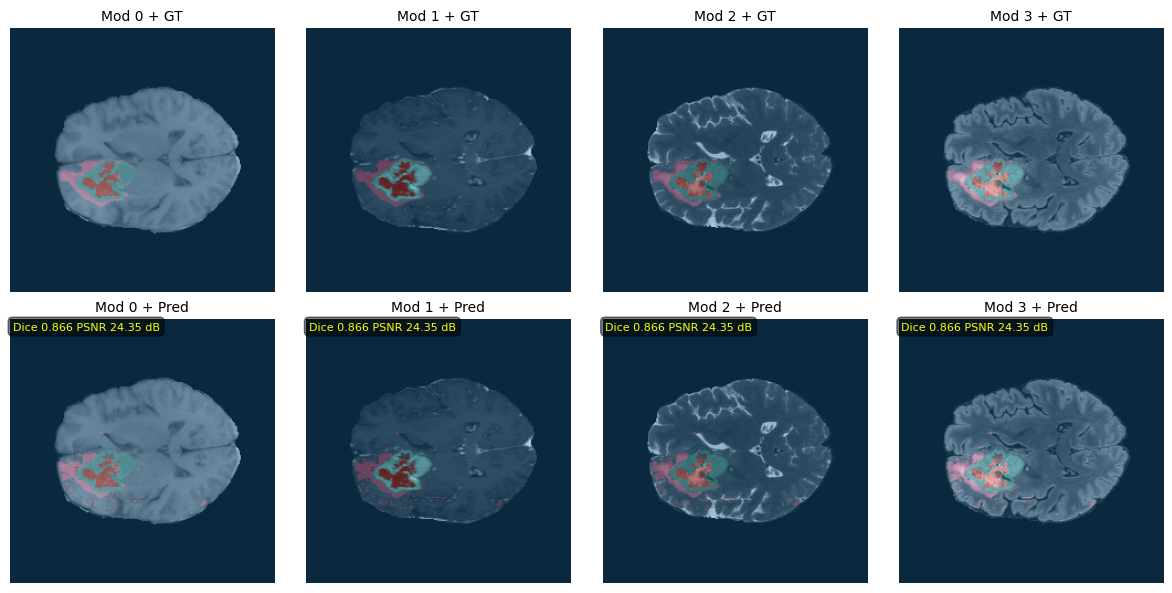

In [17]:
import matplotlib.pyplot as plt
mid_z = pred_vol.shape[2]//2
import numpy as _np

def _dice_macro_slice(pred2d, true2d, num_classes=4):
    scores = []
    for c in range(num_classes):
        p = (pred2d == c)
        t = (true2d == c)
        inter = (p & t).sum()
        denom = p.sum() + t.sum()
        if denom > 0:
            scores.append((2*inter + 1e-6) / (denom + 1e-6))
    return float(_np.mean(scores)) if len(scores)>0 else float('nan')

def _psnr_slice(pred2d, true2d, max_val=3.0):
    mse = _np.mean((_np.asarray(pred2d, dtype=_np.float32) - _np.asarray(true2d, dtype=_np.float32))**2)
    if mse <= 1e-12:
        return float('inf')
    return float(10.0 * _np.log10((max_val*max_val) / (mse + 1e-12)))

def visualize_modalities_with_overlays(mods, seg_gt, seg_pred, z):
    M = mods.shape[0]
    fig, axes = plt.subplots(2, M, figsize=(3*M, 6))
    if M == 1:
        axes = _np.array([[axes[0]],[axes[1]]], dtype=object)
    for m in range(M):
        ax_gt = axes[0, m]
        ax_pred = axes[1, m]
        # Ground truth overlay
        ax_gt.imshow(mods[m,:,:,z], cmap='gray')
        ax_gt.imshow(seg_gt[:,:,z], cmap='tab10', alpha=0.35, vmin=0, vmax=3)
        ax_gt.set_title(f'Mod {m} + GT', fontsize=10)
        ax_gt.axis('off')
        # Prediction overlay with metrics annotation box
        ax_pred.imshow(mods[m,:,:,z], cmap='gray')
        ax_pred.imshow(seg_pred[:,:,z], cmap='tab10', alpha=0.35, vmin=0, vmax=3)
        d = _dice_macro_slice(seg_pred[:,:,z], seg_gt[:,:,z], num_classes=4)
        p = _psnr_slice(seg_pred[:,:,z], seg_gt[:,:,z], max_val=3.0)
        ax_pred.set_title(f'Mod {m} + Pred', fontsize=10)
        ax_pred.text(0.01, 0.99, f'Dice {d:.3f} PSNR {p:.2f} dB',
                   transform=ax_pred.transAxes, ha='left', va='top', fontsize=8,
                   color='yellow', bbox=dict(boxstyle='round', fc='black', alpha=0.5, pad=0.4))
        ax_pred.axis('off')
    plt.tight_layout()
    plt.show()

# Show current validation case slice with metrics (non-overlapping)
visualize_modalities_with_overlays(val_case['mods'], true_vol, pred_vol, mid_z)


## Save Parameters
We save learned parameters for reuse.

In [18]:
flat_params = {}
for i, layer in enumerate(params):
    flat_params[f'W_{i}'] = np.array(layer['W'])
    flat_params[f'b_{i}'] = np.array(layer['b'])
np.savez_compressed(SAVE_PATH, **flat_params)
print('Saved parameters to', SAVE_PATH)


Saved parameters to ../artifacts/inr_brats23.npz


## Next Steps
- Increase TRAIN_STEPS, CASE_LIMIT for better accuracy.
- Add class rebalancing or focal loss (BraTS class imbalance).
- Integrate data augmentations (intensity shifts, coordinate jitter).
- Compare against nnU-Net baseline metrics.
- Explore multi-resolution coordinate conditioning or SIREN activations.

## Hold-Out Case Evaluation
We evaluate the model on a case not included in the training subset (beyond CASE_LIMIT). If unavailable, we skip.


Hold-out cases available: 1235
Hold-out Dice: {0: np.float64(0.9975138941079946), 1: np.float64(0.14060061482287536), 2: np.float64(0.49087086722035733), 3: np.float64(0.5844666383384566)}


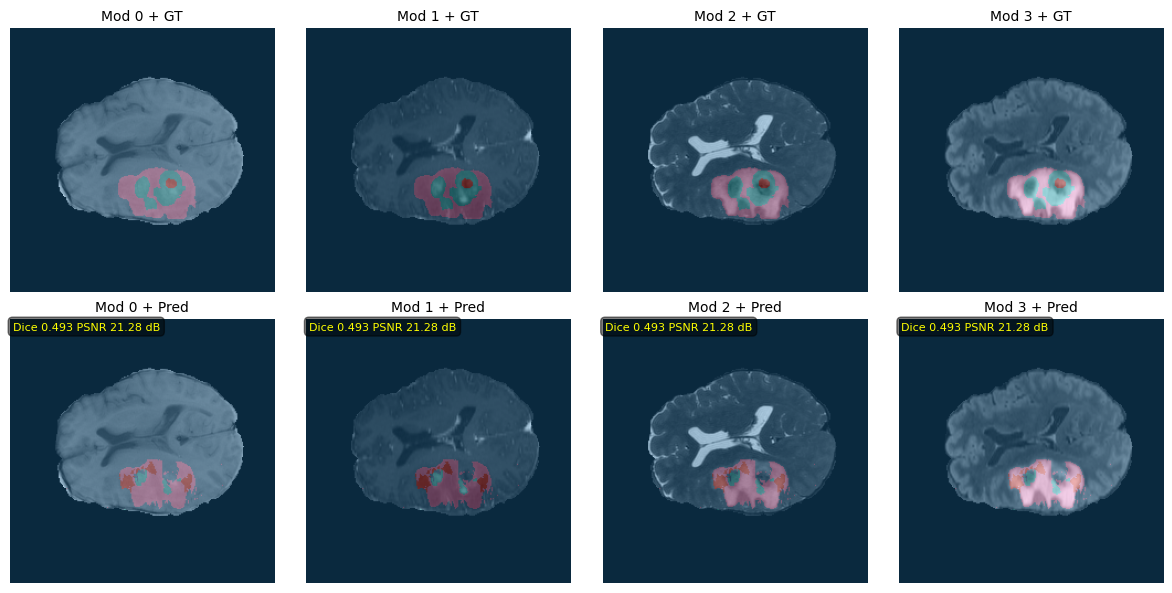

In [19]:
all_cases_full = find_cases(DATA_ROOT)
extra_cases = all_cases_full[CASE_LIMIT:]
print('Hold-out cases available:', len(extra_cases))
if len(extra_cases) > 0:
    hold_case_path = extra_cases[1]
    hold_mods, hold_seg = load_case(hold_case_path)
    hold_case_data = {'mods': hold_mods, 'seg': hold_seg}
    hold_pred, hold_true = predict_volume(params, hold_case_data, chunk=120000)
    hold_scores = dice_score(hold_pred, hold_true, NUM_CLASSES)
    print('Hold-out Dice:', hold_scores)
    mid_z_hold = hold_pred.shape[2]//2
    visualize_modalities_with_overlays(hold_mods, hold_true, hold_pred, mid_z_hold)
else:
    print('No hold-out case beyond training CASE_LIMIT to evaluate.')


## Interactive Viewer (Hold-outs)
Use the dropdown to select a hold-out case and slider to browse slices. The layout (all modalities with GT and Pred overlays) remains fixed; only the slice changes.

In [20]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pathlib as _pl

# Prepare hold-out cases list
all_cases_full = find_cases(DATA_ROOT)
extra_cases = all_cases_full[CASE_LIMIT:]
case_options = [(p.name, str(p)) for p in extra_cases]
print('Hold-out cases:', len(case_options))

hold_pred_cache = {}  # path -> pred volume
state = {'mods': None, 'true': None, 'pred': None}

def load_and_predict_cached(case_path_str):
    p = _pl.Path(case_path_str)
    mods, seg = load_case(p)
    if case_path_str not in hold_pred_cache:
        pred, _ = predict_volume(params, {'mods': mods, 'seg': seg}, chunk=120000)
        hold_pred_cache[case_path_str] = pred
    return mods, seg, hold_pred_cache[case_path_str]

out = widgets.Output()
if len(case_options) == 0:
    print('No hold-out cases available to visualize.')
else:
    dd_hold = widgets.Dropdown(options=case_options, description='Hold-out:')
    # Initialize
    state['mods'], state['true'], state['pred'] = load_and_predict_cached(dd_hold.value)
    z_slider = widgets.IntSlider(min=0, max=int(state['pred'].shape[2]-1), value=int(state['pred'].shape[2]//2), description='Slice z')

    def render_slice(z):
        with out:
            clear_output(wait=True)
            visualize_modalities_with_overlays(state['mods'], state['true'], state['pred'], int(z))

    def on_slice_change(change):
        render_slice(change['new'])

    def on_case_change(change):
        state['mods'], state['true'], state['pred'] = load_and_predict_cached(change['new'])
        z_slider.max = int(state['pred'].shape[2]-1)
        z_slider.value = int(state['pred'].shape[2]//2)
        render_slice(z_slider.value)

    z_slider.observe(on_slice_change, names='value')
    dd_hold.observe(on_case_change, names='value')
    display(widgets.VBox([dd_hold, z_slider, out]))
    render_slice(z_slider.value)


Hold-out cases: 1235
